# SageMaker Tune in action

In this notebook, we will show how to tune hyperparameters with Sagemaker Tune. In particular, we will show how to tune the hyperparameters of a computer-vision model on a local machine and then on SageMaker with many more machines.

## Setup

In [16]:
cd /home/ec2-user/SageMaker/sagemaker-tune

/home/ec2-user/SageMaker/sagemaker-tune


In [ ]:
# temporary note need ssh key since the repo is private or manual upload.
!git clone git@github.com:awslabs/sagemaker-tune.git

In [1]:
!git checkout blog

Already on 'blog'
Your branch is up to date with 'origin/blog'.


In [2]:
!git pull

Already up to date.


In [6]:
!pip install -e .[extra]

Obtaining file:///home/ec2-user/SageMaker/sagemaker-tune
     |████████████████████████████████| 54.7 MB 6.7 MB/s eta 0:00:01     |█████████████████████▊          | 37.0 MB 6.7 MB/s eta 0:00:03
     |████████████████████████████████| 100 kB 17.5 MB/s eta 0:00:01
     |████████████████████████████████| 72 kB 1.1 MB/s s eta 0:00:01
     |████████████████████████████████| 3.9 MB 61.0 MB/s eta 0:00:01
     |████████████████████████████████| 124 kB 134.6 MB/s eta 0:00:01
  Created wheel for autograd: filename=autograd-1.3-py3-none-any.whl size=47988 sha256=ddb6ed1623849136df571b82c0ead9e91d9f8d4835135bd2916f7afb4813f413
  Stored in directory: /home/ec2-user/.cache/pip/wheels/b2/a5/3c/929b91003a3b75a175ccba7cef35200a1890cdb46903f18072
Successfully built autograd
  Running setup.py develop for sagemaker-tune
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_latest_p36/bin/python -m pip install --upgrade pip' command.


In [2]:
cd /home/ec2-user/SageMaker/sagemaker-tune/blog-post/

/home/ec2-user/SageMaker/sagemaker-tune/blog-post


## How to enable tuning


To tune hyperparameters, you will need: 
* 1) a main script that takes hyperparameters as arguments
* 2) to add one line to report results once they are obtained

Let us take a look at a simplified example of a script that has learning_rate, dropout_rate as hyperparameters and report accuracy over the training epochs.

```python
from argparse import ArgumentParser
from sagemaker_tune.report import Reporter

if __name__ == '__main__':
    parser = ArgumentParser()
    parser.add_argument('--learning_rate', type=float)
    parser.add_argument('--dropout_rate', type=float)

    args, _ = parser.parse_known_args()
    report = Reporter()

    for epoch in range(args.epochs):
        # ... train model and get accuracy        
        accuracy = compute_accuracy()
        
        # Feed the score back to Sagemaker Tune.
        report(epoch=epoch, accuracy=accuracy)
```

In our case, we are going to use a slightly more complex case that trains a computer-vision model adapted from Sagemaker examples [[link]](https://github.com/aws/amazon-sagemaker-examples/blob/master/sagemaker-python-sdk/pytorch_cnn_cifar10/source/cifar10.py).

Let us have a look to the full code of the example.

In [3]:
!pygmentize train_cifar10.py

import argparse
import json
import logging
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.optim
import torch.utils.data
import torch.utils.data.distributed
import torchvision
import torchvision.models
import torchvision.transforms as transforms
from tqdm import tqdm

from sagemaker_tune.num_gpu import get_num_gpus
from sagemaker_tune.report import Reporter

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)

classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")


# https://github.com/pytorch/tutorials/blob/master/beginner_source/blitz/cifar10_tutorial.py#L118
class Net(nn.Module):
    def __init__(self, dropout_rate: float = 0.0):
        super(Net, self).__init__()
        assert 0 <= dropout_rate <= 1
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120

Since the example requires cifar10 dataset, we first download it locally.

In [4]:
from utils_cifar import get_train_data_loader, get_test_data_loader, imshow, classes

trainloader = get_train_data_loader()
testloader = get_test_data_loader()

Files already downloaded and verified
Files already downloaded and verified


We are now all settled to launch tuning of hyperparameters in this particular case.

The following code defines the search space for the hyperparameters (dropout, learning-rate, momentum) and the scheduler being used (Hyperband).

In [5]:
import logging
logging.getLogger().setLevel(logging.INFO)
from sagemaker_tune.backend.local_backend import LocalBackend
from sagemaker_tune.tuner import Tuner
from sagemaker_tune.search_space import loguniform, uniform
from sagemaker_tune.stopping_criterion import StoppingCriterion
from sagemaker_tune.optimizer.schedulers.hyperband import HyperbandScheduler


max_epochs = 100
config_space = {
    "epochs": max_epochs,
    "lr": loguniform(1e-5, 1e-1),
    "momentum": uniform(0.8, 1.0),
    "dropout_rate": loguniform(1e-5, 1.0),
}


scheduler = HyperbandScheduler(
    config_space,
    max_t=max_epochs,
    resource_attr='epoch',
    searcher='random',
    metric="val_acc",
    mode="max",
)

We are now ready to define and launch the tuning of our hyperparameters.

To do so, we define the number of workers that evaluates trials concurrently and how long we are willing to wait.

Importantly, we use the local backend to evaluate our training script `"train_cifar10.py"`. This means that the tuning will run on the local machine with one subprocess per worker.

In [6]:
tuner = Tuner(
    backend=LocalBackend(entry_point="train_cifar10.py"),
    scheduler=scheduler,
    stop_criterion=StoppingCriterion(max_wallclock_time=3600),
    n_workers=4,
)

tuner.run()


INFO:sagemaker_tune.tuner:results of trials will be saved on /home/ec2-user/sagemaker-tune/train-cifar10-2021-11-05-15-22-27-531
INFO:sagemaker_tune.optimizer.schedulers.searchers.bayesopt.utils.debug_log:[0: random]
lr: 0.0010000000000000002
momentum: 0.9
dropout_rate: 0.003162277660168379
INFO:sagemaker_tune.optimizer.schedulers.hyperband:trial_id 0 starts (first milestone = 1)
INFO:root:Detected 4 GPUs
INFO:root:running subprocess with command: /home/ec2-user/anaconda3/envs/pytorch_latest_p36/bin/python train_cifar10.py --epochs 100 --lr 0.0010000000000000002 --momentum 0.9 --dropout_rate 0.003162277660168379 --smt_checkpoint_dir /home/ec2-user/sagemaker-tune/train-cifar10-2021-11-05-15-22-27-531/0/checkpoints
INFO:sagemaker_tune.tuner:(trial 0) - scheduled config {'epochs': 100, 'lr': 0.0010000000000000002, 'momentum': 0.9, 'dropout_rate': 0.003162277660168379}
INFO:sagemaker_tune.optimizer.schedulers.searchers.bayesopt.utils.debug_log:[1: random]
lr: 0.03789103563381808
momentum: 

--------------------
Resource summary:
 trial_id      status  iter  epochs        lr  momentum  dropout_rate  epoch  val_acc  worker-time
        0   Completed   100     100  0.001000  0.900000      0.003162    100   0.6052         2897
        1  InProgress     1     100  0.037891  0.871333      0.007866      1   0.0989           31
        2  InProgress     3     100  0.000082  0.837961      0.984734      3   0.1693           88
        3  InProgress     3     100  0.029322  0.839999      0.001208      3   0.1011           88
        4  InProgress     3     100  0.000011  0.933272      0.000013      3   0.1225           86
        5  InProgress     9     100  0.005805  0.860568      0.046477      9   0.4869          260
        6  InProgress   100     100  0.000373  0.872700      0.000116    100   0.6427         2901
        7  InProgress     1     100  0.000011  0.837150      0.010517      1   0.1224           29
        8  InProgress     9     100  0.001983  0.921045      0.011108 

As soon as the tuning starts, we see this line:

```
INFO:sagemaker_tune.tuner:results of trials will be saved on /home/ec2-user/sagemaker-tune/train-cifar10-2021-11-05-15-22-27-531
```

All the log of the trials are stored there for further analysis.

At any time during the tuning, we can easily get the results obtained so far by calling 
`load_experiment("train-cifar10-2021-11-05-15-22-27-531")` and then plot the best result obtained since the start of the tuning:


Experiment train-cifar10-2021-11-05-15-22-27-531 contains 482 evaluations from 53 trials when tuning val_acc on train_cifar10 with HyperbandScheduler.


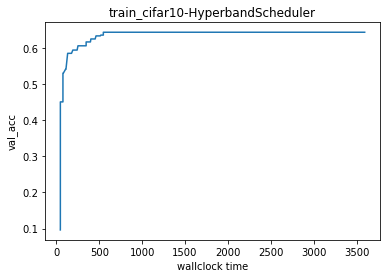

In [7]:
from sagemaker_tune.experiments import load_experiment
tuning_experiment = load_experiment("train-cifar10-2021-11-05-15-22-27-531")
tuning_experiment.plot()

A lot more of information is also available since all the results obtained over time are stored. For instance, we can plot the metric obtained for each trials over time (recall that 4 trials were running asynchronously).
We clearly see the effect of Hyperband that only lets the trials with best results continue training. This allows to drastically speed-up the tuning.

INFO:numexpr.utils:Note: NumExpr detected 48 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.


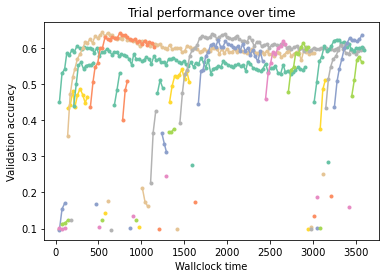

In [8]:
import matplotlib.pyplot as plt
from matplotlib import cm

df = tuning_experiment.results
cmap = cm.get_cmap("Set2")
for trial_id in sorted(df.trial_id.unique()):
    dd = df[df.trial_id == trial_id]
    plt.plot(
        dd[SMT_TUNER_TIME],
        dd[tuning_experiment.metric_name()],
        marker='.', color=cmap(trial_id % len(cmap.colors)), label=trial_id
    )
plt.xlabel("Wallclock time")
plt.ylabel("Validation accuracy")
plt.title("Trial performance over time")
plt.show()

The previous example showed how to tune hyperparameter on a local machine. It can be used to tune your hyperparameters or your own machine for instance. 

Sometimes, we need more powerful machine or a larger number which motivates the use of cloud ressources. In those cases, SageMaker tune provides a very simple way to run tuning on Sagemaker. Let us have a look.

We first upload cifar10 dataset to s3 so that it is available on cloud machines.


In [9]:
import sagemaker

sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix = "sagemaker/DEMO-pytorch-cnn-cifar10"
role = sagemaker.get_execution_role()

inputs = sagemaker_session.upload_data(path="data", bucket=bucket, key_prefix="data/cifar10")

We now define our new backend to specify that we want trials to be executed on SageMaker. 
We use SageMaker framework (`PyTorch`) in this particular example since we have a pytorch training script but any SageMaker framework can be used (XGBoost, TensorFlow, SKlearn, HuggingFace, ...). 

If you do not know what a SageMaker framework is, it is a Python wrapper that allows you to run Machine Learning code easily by providing pre-made docker images that works seamlessly on CPU and GPU for many framework versions. In this particular example for instance, all we need to do is to instantiate the wrapper PyTorch with our training script.

In [17]:
from sagemaker.pytorch import PyTorch
from sagemaker_tune.backend.sagemaker_backend.sagemaker_utils import get_execution_role
from sagemaker_tune.backend.sagemaker_backend.sagemaker_backend import SagemakerBackend

backend = SagemakerBackend(
    sm_estimator=PyTorch(
        entry_point="./train_cifar10.py",
        instance_type="ml.g4dn.xlarge",
        instance_count=1,
        role=get_execution_role(),
        framework_version='1.7.1',
        py_version='py3',
    ),
    inputs=inputs,
)


INFO:sagemaker_tune.backend.sagemaker_backend.sagemaker_utils:No Sagemaker role passed as environment variable $AWS_ROLE, inferring it.


In [18]:
scheduler = HyperbandScheduler(
    config_space,
    max_t=max_epochs,
    resource_attr='epoch',
    searcher='random',
    metric="val_acc",
    mode="max",
)


We can now run again our tuning, this time we use 20 workers each having its own GPU. 

In [ ]:
tuner = Tuner(
    backend=backend,
    scheduler=scheduler,
    stop_criterion=StoppingCriterion(max_wallclock_time=3600, max_cost=20.0),
    n_workers=20,
    tuner_name="cifar10-on-sagemaker"
)

tuner.run()


INFO:sagemaker_tune.tuner:results of trials will be saved on /home/ec2-user/sagemaker-tune/cifar10-on-sagemaker-2021-11-08-08-21-33-114
INFO:sagemaker_tune.optimizer.schedulers.searchers.bayesopt.utils.debug_log:[0: random]
lr: 0.0010000000000000002
momentum: 0.9
dropout_rate: 0.003162277660168379
INFO:sagemaker_tune.optimizer.schedulers.hyperband:trial_id 0 starts (first milestone = 1)
INFO:root:Trial 0 will checkpoint results to s3://sagemaker-us-west-2-760692251996/sagemaker-tune/cifar10-on-sagemaker-2021-11-08-08-21-33-114/0/.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: cifar10-on-sagemaker-2021-11-08-08-21-33-114-0
INFO:sagemaker_tune.backend.sagemaker_backend.sagemaker_backend:scheduled cifar10-on-sagemaker-2021-11-08-08-21-33-114-0 for trial-id 0
INFO:sagemaker_tune.tuner:(trial 0) - scheduled config {'epochs': 10

After the instance starts their training, you will see the status update as in the local case.
An important difference is that the total estimated dollar-cost is displayed as well the cost of workers.


```
trial_id      status  iter  dropout_rate  epochs        lr  momentum  epoch  val_acc  worker-time  worker-cost
        0  InProgress     1      0.003162      30  0.001000  0.900000    1.0   0.4518         50.0     0.010222
        1  InProgress     1      0.037723      30  0.000062  0.843500    1.0   0.1202         50.0     0.010222
        2  InProgress     1      0.000015      30  0.000865  0.821807    1.0   0.4121         50.0     0.010222
        3  InProgress     1      0.298864      30  0.006991  0.942469    1.0   0.2283         49.0     0.010018
        4  InProgress     0      0.000017      30  0.028001  0.911238      -        -            -            -
        5  InProgress     0      0.000144      30  0.000080  0.870546      -        -            -            -
6 trials running, 0 finished (0 until the end), 387.53s wallclock-time, 0.04068444444444444$ estimated cost
```

Since we specified `max_wallclock_time=3600` and `max_cost=20.0`, the tuning will stops when the wallclock time or estimated cost goes above the bound. In addition to providing a sense of the spending, the cost can also be optimized with our multiobjective optimizers, see this [link](https://github.com/awslabs/sagemaker-tune/blob/main/examples/launch_moasha_instance_tuning.py) for an example.

Finally, we can plot the performance obtained in the same way as for the local case.


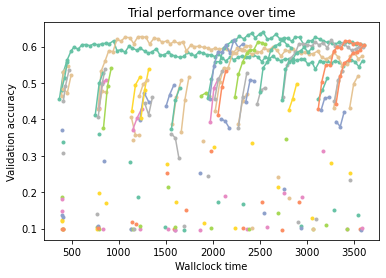

In [25]:
df = tuning_experiment.results

cmap = cm.get_cmap("Set2")
for trial_id in sorted(df.trial_id.unique()):
    dd = df[df.trial_id == trial_id]
    plt.plot(
        dd[SMT_TUNER_TIME],
        dd[tuning_experiment.metric_name()],
        marker='.', color=cmap(trial_id % len(cmap.colors)), label=trial_id
    )
plt.xlabel("Wallclock time")
plt.ylabel("Validation accuracy")
plt.title("Trial performance over time")
plt.show()